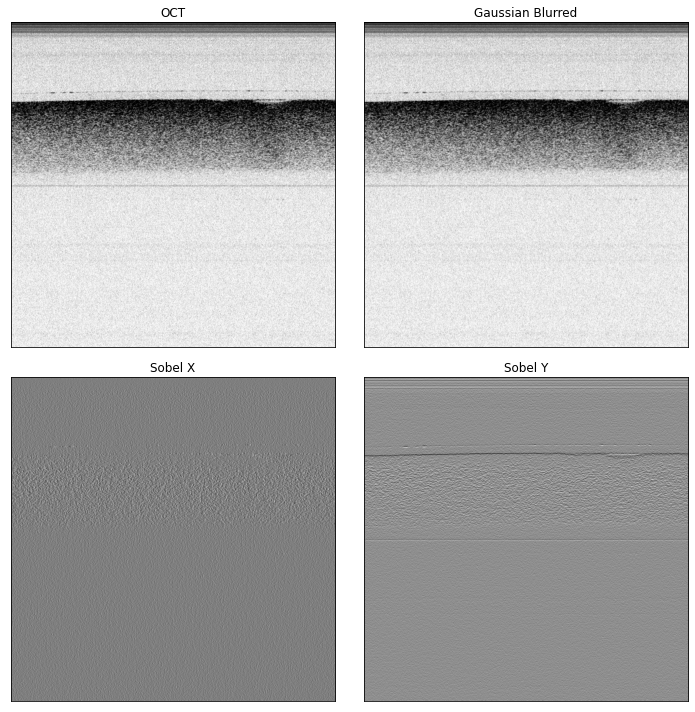

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = r"data\phantom_1\image_Mark_D10\ExVivo_Brain_30_A2_T2_2017-10-03_0000.oct.csv"
img=pd.read_csv(path).to_numpy()

img_blur = cv2.GaussianBlur(img,(3,3),0) # suppress noise
sobelx = cv2.Sobel(img_blur,cv2.CV_64F,1,0,ksize=5) # x derivative
sobely = cv2.Sobel(img_blur,cv2.CV_64F,0,1,ksize=5) # y derivative
# normalize pixel values to [0, 1]
sobely_norm = cv2.normalize(np.abs(sobely), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.subplots(2,2,figsize=(10,10))
plt.subplot(2,2,1)
plt.title('OCT'), plt.xticks([]), plt.yticks([])
plt.imshow(img, cmap='gray')
plt.subplot(2,2,2)
plt.title('Gaussian Blurred'), plt.xticks([]), plt.yticks([])
plt.imshow(img_blur, cmap='gray')
plt.subplot(2,2,3)
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.imshow(sobelx, cmap='gray')
plt.subplot(2,2,4)
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.imshow(sobely, cmap='gray')
plt.tight_layout()
plt.show()

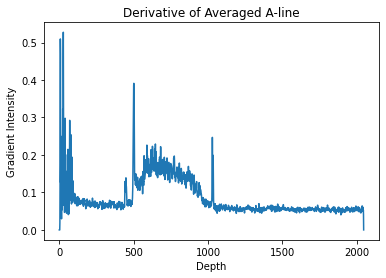

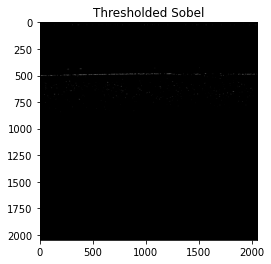

y_mean: 516.7927328556807
y_std: 125.47049439028177


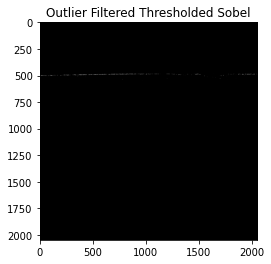

In [6]:
# edges are rapid changes in pixel intensity
Aline_sobel = np.mean(sobely_norm[:,0:300], axis=1)
depth = np.arange(2047)
plt.plot(depth, Aline_sobel)
plt.title("Derivative of Averaged A-line")
plt.xlabel("Depth")
plt.ylabel("Gradient Intensity")
plt.show()

threshold = 0.6
ret, edge_mtx = cv2.threshold(sobely_norm, threshold, 1, cv2.THRESH_BINARY) # threshold edge and non-edge
edgept_rows, edgept_cols = np.where(edge_mtx==1) # coordinates of each edge point
plt.title('Thresholded Sobel')
plt.imshow(edge_mtx, cmap='gray')
plt.show()

y_mean = np.mean(edgept_rows)
y_std = np.std(edgept_rows)
epsilon = 30
print("y_mean: " + str(y_mean))
print("y_std: " + str(y_std))

# look at each edge point and remove outlier edge pts
for i in range(len(edgept_cols)):
    col_coord = edgept_cols[i]
    row_coord = edgept_rows[i]
    
    if np.abs(row_coord - y_mean) > epsilon: 
        edge_mtx[row_coord, col_coord] = 0

plt.title("Outlier Filtered Thresholded Sobel")
plt.imshow(edge_mtx, cmap='gray')
plt.show() 

# coordinates of valid edge points
edgept_rows, edgept_cols = np.where(edge_mtx==1)
edge_vector = np.zeros(2048)
edge_vector[0] = y_mean

# compute average row number/y value of edge pts in a given column
def y_avg(indices): 
    total = 0
    count = 0
    
    for i in range(len(indices)):
        total += edgept_rows[indices[i]]
        count += 1
        
    return total/count
        
for i in range(1, 2048):
    indices = np.asarray(np.where(edgept_cols == i)).flatten()
    
    if(len(indices)==0): # no relevant edge pts in column i
        edge_vector[i] = edge_vector[i-1]
    else:
        edge_vector[i] = y_avg(indices)

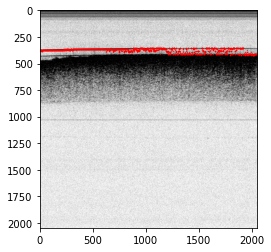

In [22]:
# outputs a vector corresponding to the top edge of the OCT image
# sobel_img should be an np array
def extract_edge(sobel_img): 
    sobel_img = cv2.normalize(np.abs(sobel_img), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    threshold = 0.6
    ret, edge_mtx = cv2.threshold(sobel_img, threshold, 1, cv2.THRESH_BINARY)
    edgept_rows, edgept_cols = np.where(edge_mtx==1)

    y_mean = np.mean(edgept_rows)
    y_std = np.std(edgept_rows)
    epsilon=30

    for i in range(len(edgept_cols)):
        col_coord = edgept_cols[i]
        row_coord = edgept_rows[i]

        if np.abs(row_coord - y_mean) > epsilon: 
            edge_mtx[row_coord, col_coord] = 0      

    edgept_rows, edgept_cols = np.where(edge_mtx==1)
    edge_vector = np.zeros(2048)
    edge_vector[0] = y_mean

    def y_avg(indices): 
        total = 0
        count = 0

        for i in range(len(indices)):
            total += edgept_rows[indices[i]]
            count += 1

        return total/count

    for i in range(1, 2048):
        indices = np.asarray(np.where(edgept_cols == i)).flatten()

        if(len(indices)==0):
            edge_vector[i] = edge_vector[i-1]
        else:
            edge_vector[i] = y_avg(indices)
            
    return edge_vector

path = r"data\phantom_1\image_Mark_D10\ExVivo_Brain_30_A2_T2_2017-10-03_0255.oct.csv"
img=pd.read_csv(path).to_numpy()
img_blur = cv2.GaussianBlur(img,(3,3),0)
sobely = cv2.Sobel(img_blur,cv2.CV_64F,0,1,ksize=5)
result = extract_edge(sobely)
plt.imshow(img, cmap='gray')
plt.scatter(np.arange(2048), result, s=0.1, color='r')

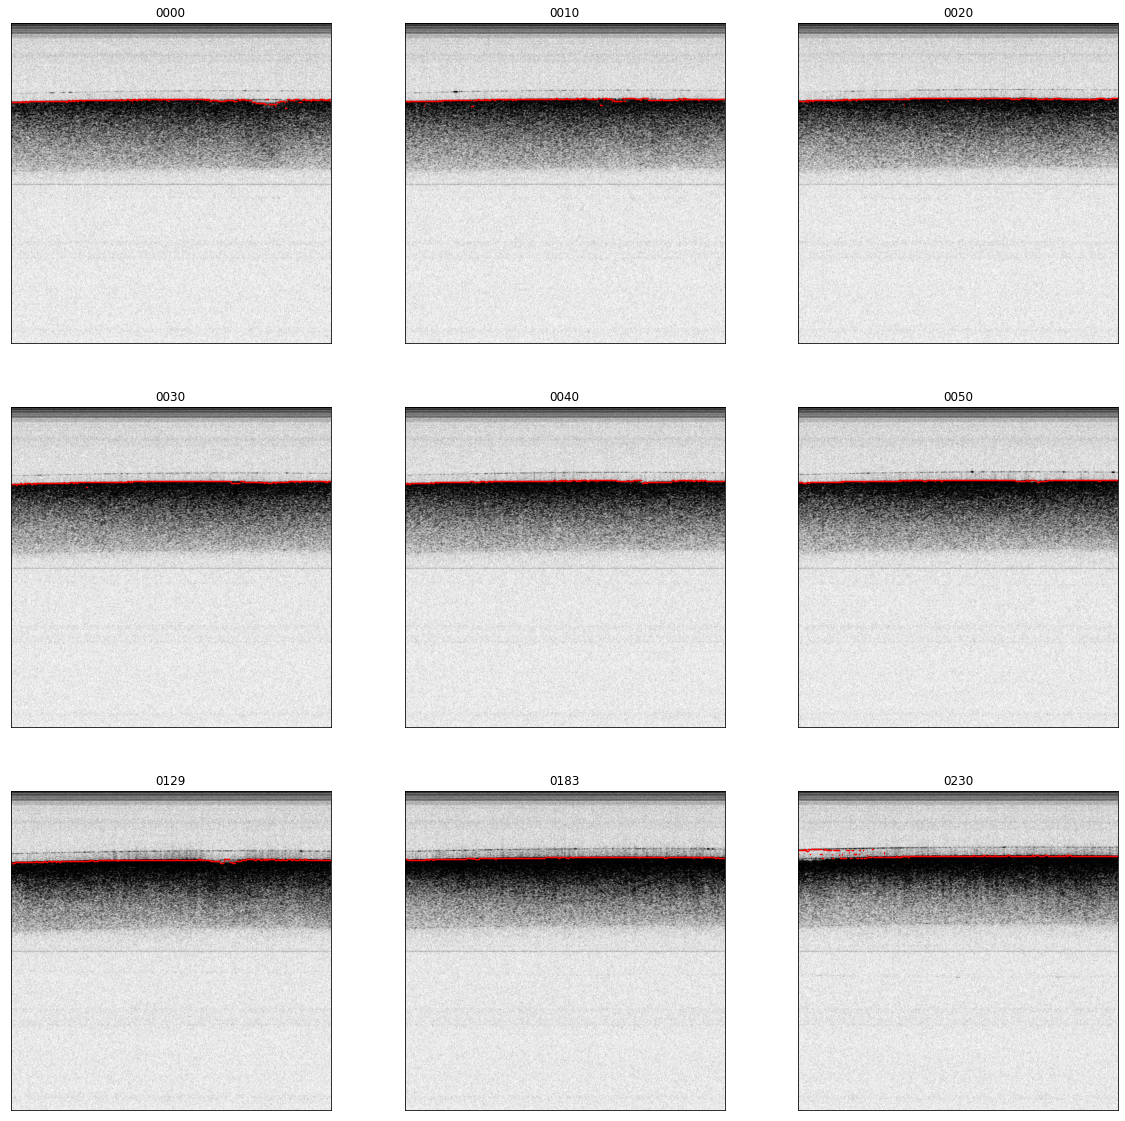

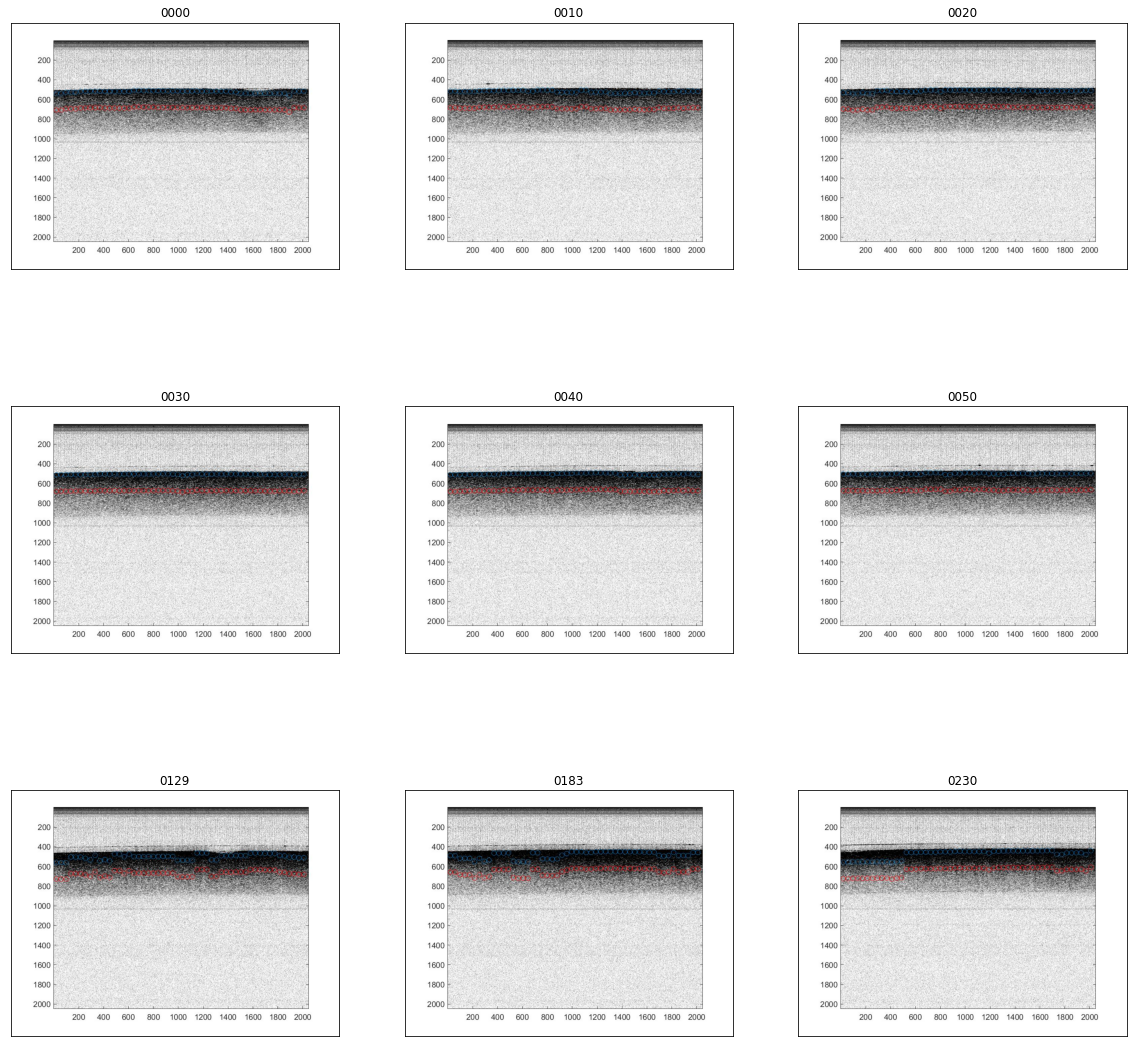

In [30]:
raw_data = ['0000','0010','0020','0030','0040','0050','0129','0183','0230']

# sobel edge detection results
path1 = r"data\phantom_1\image_Mark_D10\ExVivo_Brain_30_A2_T2_2017-10-03_"
plt.subplots(3,3,figsize=(20,20))
img_num = 1

for i in raw_data:
    input_path = path1 + i + ".oct.csv"
    img=pd.read_csv(input_path).to_numpy() # load raw OCT data (csv) into np array
    img_blur = cv2.GaussianBlur(img,(3,3),0)
    sobely = cv2.Sobel(img_blur,cv2.CV_64F,0,1,ksize=5)
    output = extract_edge(sobely)
    
    plt.subplot(3,3,img_num)
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(np.arange(2048), output, s=0.05, color='r')
    plt.imshow(img, cmap='gray')
    
    img_num += 1
    
plt.show()

# previous edge detection results
path2 = r"D:\Brain_tumor_2017-10-02\ExVivo\30min\rawdata\1\image_Mark_D10\ExVivo_Brain_30_A2_T2_2017-10-03_"
plt.subplots(3,3,figsize=(20,20))
img_num = 1

for i in raw_data:
    input_path = path2 + i + ".oct.jpg"
    img=plt.imread(input_path)

    plt.subplot(3,3,img_num)
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
    
    img_num += 1
    
plt.show()